In [1]:
import os
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_validate, train_test_split
from statistics import mean
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore") 

In [2]:
for dirname, _, filenames in os.walk('/home/centos/moon/ktw/walmart-recruiting-store-sales-forecasting/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/centos/moon/ktw/walmart-recruiting-store-sales-forecasting/data/features.csv.zip
/home/centos/moon/ktw/walmart-recruiting-store-sales-forecasting/data/sampleSubmission.csv.zip
/home/centos/moon/ktw/walmart-recruiting-store-sales-forecasting/data/stores.csv
/home/centos/moon/ktw/walmart-recruiting-store-sales-forecasting/data/test.csv.zip
/home/centos/moon/ktw/walmart-recruiting-store-sales-forecasting/data/train.csv.zip


In [3]:
df_train = pd.read_csv("/home/centos/moon/ktw/walmart-recruiting-store-sales-forecasting/data/train.csv.zip", compression='zip')
df_features = pd.read_csv("/home/centos/moon/ktw/walmart-recruiting-store-sales-forecasting/data/features.csv.zip", compression='zip')
df_test = pd.read_csv("/home/centos/moon/ktw/walmart-recruiting-store-sales-forecasting/data/test.csv.zip", compression='zip')
df_stores = pd.read_csv("/home/centos/moon/ktw/walmart-recruiting-store-sales-forecasting/data/stores.csv")

In [4]:
df_train.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


In [5]:
df_test.tail()

,Store,Dept,Date,IsHoliday
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False
115063,45,98,2013-07-26,False


In [6]:
df_stores.tail()

,Store,Type,Size
40,41,A,196321
41,42,C,39690
42,43,C,41062
43,44,C,39910
44,45,B,118221


In [7]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [8]:
df_train = pd.merge(df_train,df_features, on = ['Store','Date','IsHoliday'],how='inner')
df_train = pd.merge(df_train,df_stores, on= 'Store',how='inner')
df_test = pd.merge(df_test,df_features, on = ['Store','Date','IsHoliday'],how='inner')
df_test = pd.merge(df_test,df_stores, on= 'Store',how='inner')

In [10]:
"train", df_train.isna().mean() 

('train',
 Store           0.000000
 Dept            0.000000
 Date            0.000000
 Weekly_Sales    0.000000
 IsHoliday       0.000000
 Temperature     0.000000
 Fuel_Price      0.000000
 MarkDown1       0.642572
 MarkDown2       0.736110
 MarkDown3       0.674808
 MarkDown4       0.679847
 MarkDown5       0.640790
 CPI             0.000000
 Unemployment    0.000000
 Type            0.000000
 Size            0.000000
 dtype: float64)

In [11]:
def convert_dates(dataframe):
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataframe['year'] = dataframe['Date'].dt.year
    dataframe['week'] = dataframe.Date.dt.week 
    
    return dataframe

df_test = convert_dates(df_test)
df_train = convert_dates(df_train)

In [12]:
to_categorical = ['Store', 'Dept', 'IsHoliday', 'Type', 'year', 'week']
for column in to_categorical:
    df_train[column] = df_train[column].astype('category')
    
df_train.dtypes

Store                 category
Dept                  category
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday             category
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                  category
Size                     int64
year                  category
week                  category
dtype: object

<AxesSubplot:>

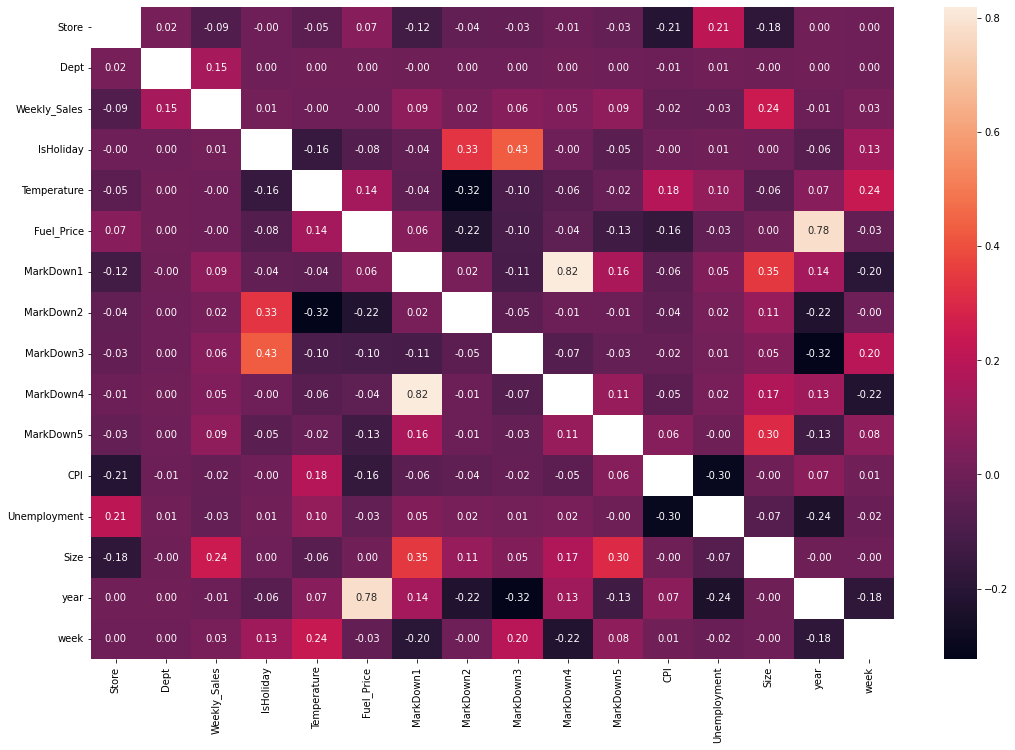

In [13]:
df_train[['Dept', 'Store', 'week', 'year', 'IsHoliday']] = df_train[['Dept', 'Store', 'week', 'year', 'IsHoliday']].astype('int')

plt.figure(figsize=(18,12))
corr = df_train.corr()
np.fill_diagonal(corr.values, np.nan)

sns.heatmap(corr, annot=True, fmt='.2f')

In [14]:
def boxplot(column, x_size=15, y_size=10):
    fig = plt.figure(figsize=(x_size,y_size))
    sns.boxplot(y=df_train.Weekly_Sales, x=df_train[column])
    plt.ylabel('Weekly_Sales')
    plt.xlabel(column)

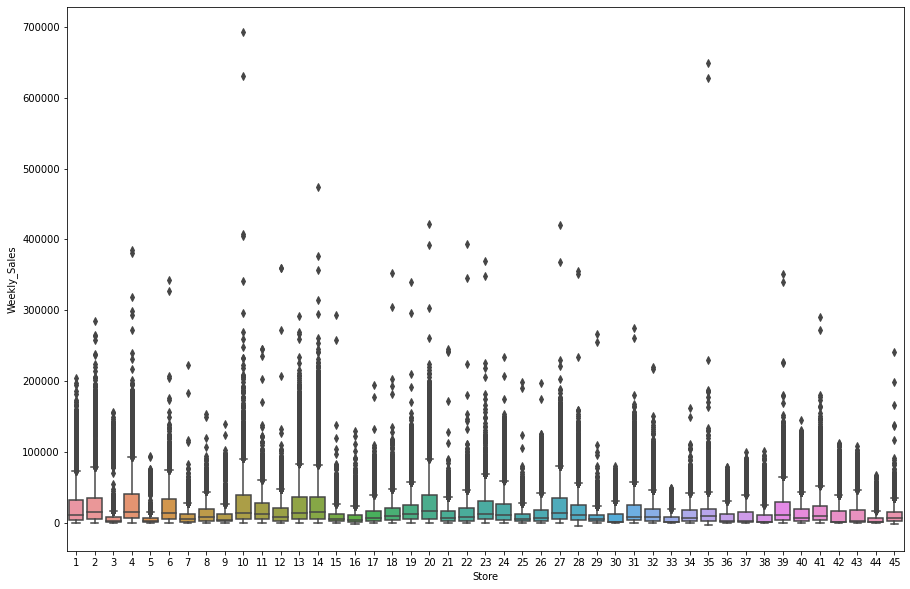

In [15]:
boxplot('Store')

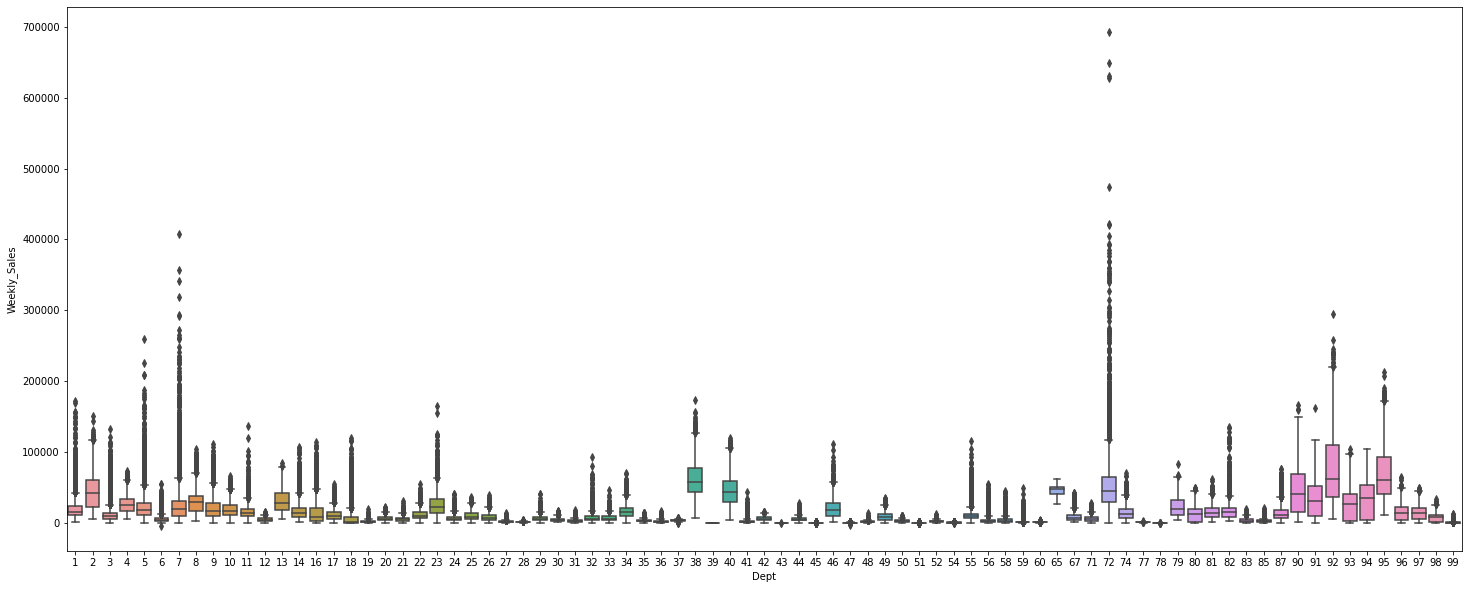

In [16]:
boxplot('Dept', x_size=25)

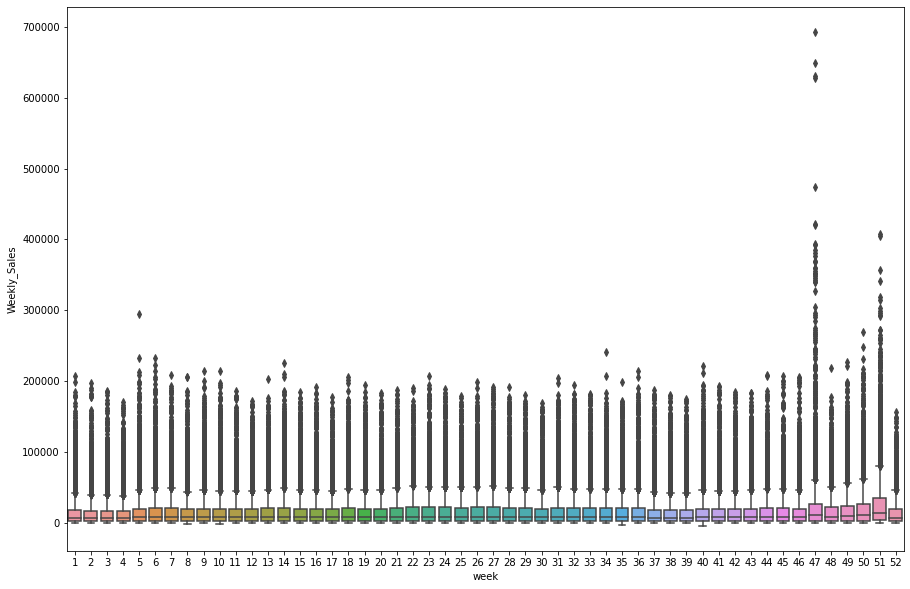

In [17]:
boxplot('week')

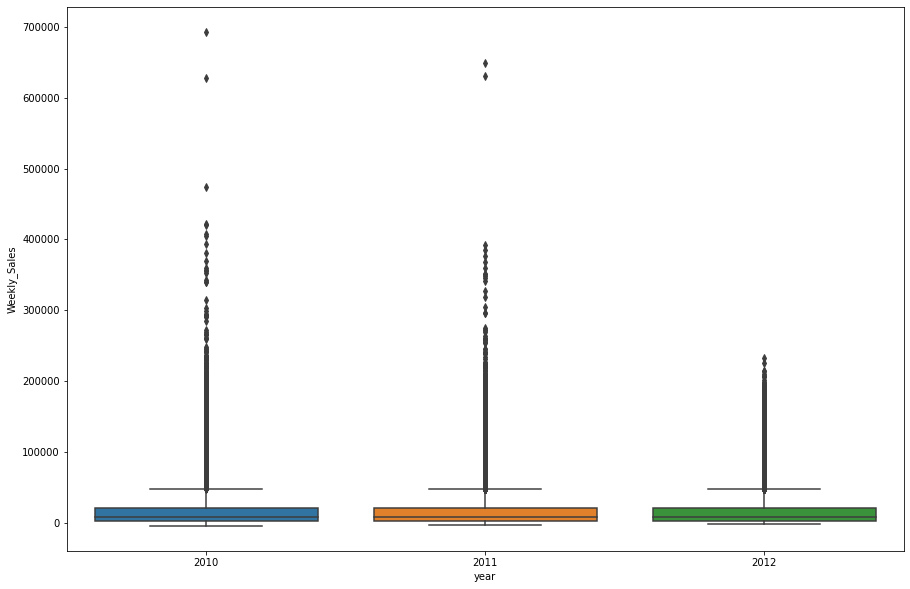

In [18]:
boxplot('year')

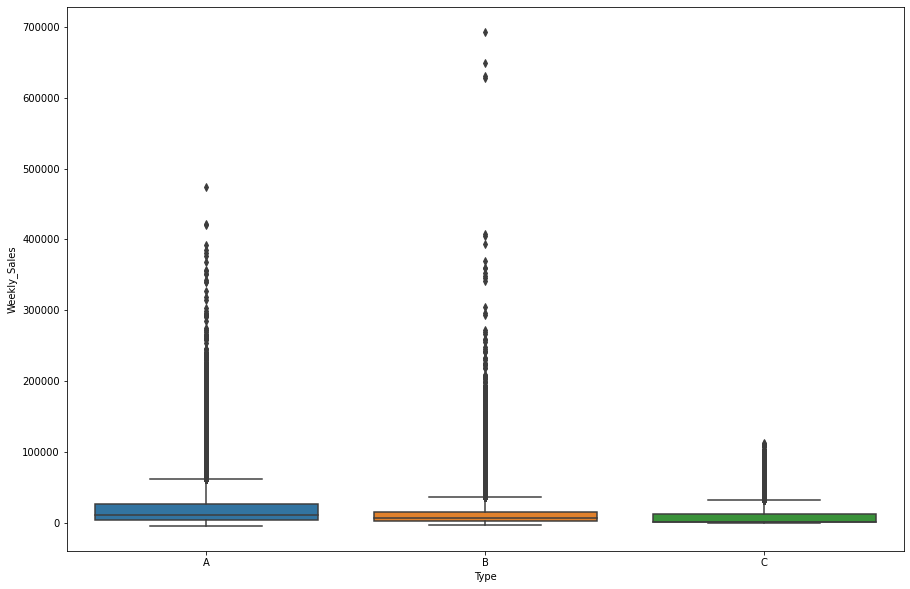

In [19]:
boxplot('Type')

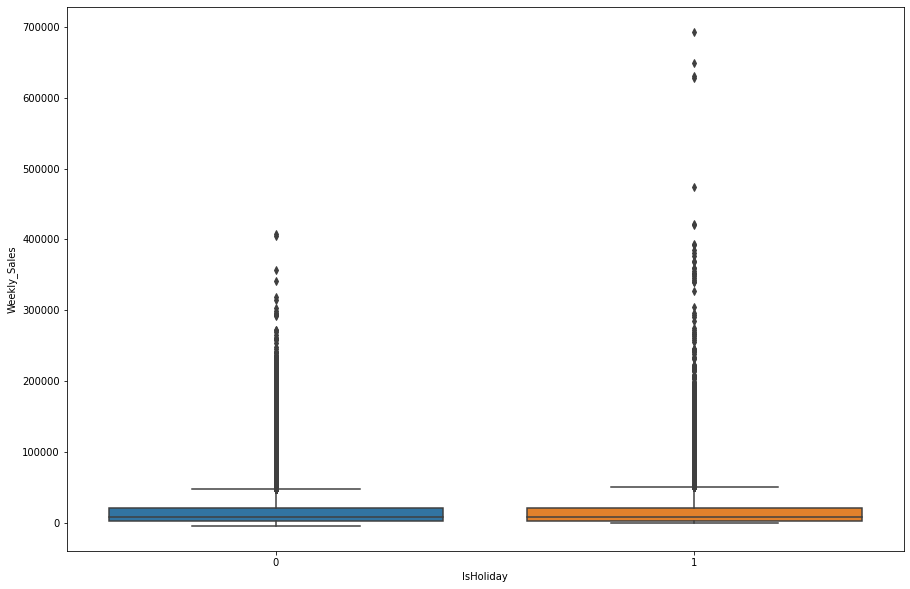

In [20]:
boxplot('IsHoliday')

In [21]:
def correlation(column):
    print("----------------------------Column name: "+column+"----------------------------")
    print("Correlation: " + str(df_train['Weekly_Sales'].corr(df_train[column])))
    print("\n")

In [22]:
correlation("CPI")
correlation("Unemployment")
correlation("Temperature")
correlation("Size")
correlation("Fuel_Price")
correlation("Unemployment")
correlation("MarkDown1")
correlation("MarkDown2")
correlation("MarkDown3")
correlation("MarkDown4")
correlation("MarkDown5")

----------------------------Column name: CPI----------------------------
Correlation: -0.02092133531881917


----------------------------Column name: Unemployment----------------------------
Correlation: -0.02586371649983765


----------------------------Column name: Temperature----------------------------
Correlation: -0.002312447010259368


----------------------------Column name: Size----------------------------
Correlation: 0.2438279922630429


----------------------------Column name: Fuel_Price----------------------------
Correlation: -0.00012029554499576825


----------------------------Column name: Unemployment----------------------------
Correlation: -0.02586371649983765


----------------------------Column name: MarkDown1----------------------------
Correlation: 0.08525115648107058


----------------------------Column name: MarkDown2----------------------------
Correlation: 0.024129610651027894


----------------------------Column name: MarkDown3----------------------------
Co

In [23]:
df_train.groupby('Store')['Size'].nunique()

Store
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
41    1
42    1
43    1
44    1
45    1
Name: Size, dtype: int64

In [24]:
df_train = pd.get_dummies(df_train, columns=['Type'])
df_train.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Size', 'year', 'week', 'Type_A',
       'Type_B', 'Type_C'],
      dtype='object')

In [25]:
df_test = pd.get_dummies(df_test, columns=['Type'])
df_test.columns

Index(['Store', 'Dept', 'Date', 'IsHoliday', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Size', 'year', 'week', 'Type_A', 'Type_B', 'Type_C'],
      dtype='object')

In [26]:
df_train.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Size', 'year', 'week', 'Type_A',
       'Type_B', 'Type_C'],
      dtype='object')

In [27]:
df_train.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                int64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Size                     int64
year                     int64
week                     int64
Type_A                   uint8
Type_B                   uint8
Type_C                   uint8
dtype: object

In [29]:
mean_sales = df_train.groupby(["Store", "Dept", "week"], as_index=False).agg({"Weekly_Sales": "mean"})
df_val = df_test.merge(mean_sales, on=['Store', 'Dept', 'week'], how='left')
sample_submission = pd.read_csv("/home/centos/moon/ktw/walmart-recruiting-store-sales-forecasting/data/sampleSubmission.csv.zip")

test_ids = df_test.Store.astype(str) + '_' + df_test.Dept.astype(str) + '_' + df_test.Date.astype(str)
sample_submission['Id'] = test_ids.values
sample_submission["Weekly_Sales"] = df_val["Weekly_Sales"]

# apparently there are some missing values. I will fill the NaN values with 0 (I know I miss some score :( ).
sample_submission = sample_submission.fillna(0)
sample_submission.to_csv('/home/centos/moon/ktw/walmart-recruiting-store-sales-forecasting/data/submission_simple_mean.csv',index=False)

In [31]:
kfold = KFold(n_splits=5, random_state=35, shuffle=True)

x = df_train.loc[:, df_train.columns != 'Weekly_Sales']
x = x.drop(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5', 'CPI', 
            'Unemployment', 'Size', 'IsHoliday', 'Type_A', 'Type_B', 'Type_C', 'year', 'Date'], axis=1)

y = df_train.loc[:, df_train.columns == 'Weekly_Sales']

models = {
    
    'xgboost' : xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10),
    'Bayesian' : BayesianRidge(),
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=1),
    'AdaBoostRegressor' : AdaBoostRegressor(n_estimators=50, learning_rate=.1, loss='square'),
    'ExtraTreesRegressor': ExtraTreesRegressor(n_estimators=50, max_features='auto', random_state=35),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=50, random_state=35),
}

for model_name, model in models.items():
    results = cross_validate(model, x,y , cv=kfold, scoring=['neg_mean_absolute_error'], return_estimator=False)
    print(model_name, mean(results['test_neg_mean_absolute_error']), mean(results['fit_time']), mean(results['score_time']))

xgboost -11520.339404483422 1.2679237842559814 0.025615835189819337
Bayesian -15113.261066093577 0.10672035217285156 0.01435699462890625
LinearRegression -15113.30858828549 0.061744308471679686 0.009374570846557618
DecisionTreeRegressor -1955.8903858631622 0.9829822540283203 0.04127559661865234
AdaBoostRegressor -12916.000806041538 24.886938190460206 0.37607502937316895
ExtraTreesRegressor -1956.6029386679952 19.297214698791503 1.8780031204223633
RandomForestRegressor -1829.1079967122062 35.11665577888489 1.714321756362915


In [32]:
x = df_train.loc[:, df_train.columns != 'Weekly_Sales']
x = x.drop(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5', 'CPI', 
            'Unemployment', 'Date'], axis=1)

y = df_train.loc[:, df_train.columns == 'Weekly_Sales']

models = {
    
    'xgboost' : xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10),
    'Bayesian' : BayesianRidge(),
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=1),
    'AdaBoostRegressor' : AdaBoostRegressor(n_estimators=50, learning_rate=.1, loss='square'),
    'ExtraTreesRegressor': ExtraTreesRegressor(n_estimators=50, max_features='auto', random_state=35),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=50, random_state=35),
}

res = {}

for model_name, model in models.items():
    results = cross_validate(model, x,y , cv=kfold, scoring=['neg_mean_absolute_error'], return_estimator=False)
    print(model_name, mean(results['test_neg_mean_absolute_error']), mean(results['fit_time']), mean(results['score_time']))

xgboost -13233.565129340544 1.0415974140167237 0.026355266571044922
Bayesian -14576.796308124582 0.22971043586730958 0.016225719451904298
LinearRegression -14577.114874505569 0.1542363166809082 0.01117401123046875
DecisionTreeRegressor -1642.665127784235 1.6715445518493652 0.059195089340209964
AdaBoostRegressor -12320.943812397092 37.61557517051697 0.41291232109069825
ExtraTreesRegressor -1451.2734535567881 35.56853189468384 2.4193445682525634
RandomForestRegressor -1343.3736559271294 61.29404501914978 2.2954599380493166


In [33]:
x = df_train.loc[:, df_train.columns != 'Weekly_Sales']
x = x.drop(['Date'], axis=1)
x = x.fillna(0)
y = df_train.loc[:, df_train.columns == 'Weekly_Sales']

models = {
    'xgboost' : xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10),
    'Bayesian' : BayesianRidge(),
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=1),
    'AdaBoostRegressor' : AdaBoostRegressor(n_estimators=50, learning_rate=.1, loss='square'),
    'ExtraTreesRegressor': ExtraTreesRegressor(n_estimators=50, max_features='auto', random_state=35),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=50, random_state=35),
}

res = {}

for model_name, model in models.items():
    results = cross_validate(model, x,y , cv=kfold, scoring=['neg_mean_absolute_error'], return_estimator=False)
    print(model_name, mean(results['test_neg_mean_absolute_error']), mean(results['fit_time']), mean(results['score_time']))

xgboost -9870.02199670254 1.751002550125122 0.031695890426635745
Bayesian -14559.921356912813 0.5154891967773437 0.023900413513183595
LinearRegression -14560.591855873698 0.4011385917663574 0.0168670654296875
DecisionTreeRegressor -1880.3044392864767 5.620046329498291 0.08172407150268554
AdaBoostRegressor -12370.474016937755 77.70661225318909 0.580118989944458
ExtraTreesRegressor -1518.6945528111582 85.10042667388916 2.660526657104492
RandomForestRegressor -1444.76859353417 181.1711361885071 2.28105149269104


In [34]:
x = df_train.loc[:, df_train.columns != 'Weekly_Sales']
x = x.drop(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5', 'CPI', 
            'Unemployment', 'Date'], axis=1)

y = df_train.loc[:, df_train.columns == 'Weekly_Sales']

extratreeregressor = ExtraTreesRegressor(n_estimators=50, max_features='auto', random_state=35)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=35)
extratreeregressor.fit(X_train, y_train)
y_pred = extratreeregressor.predict(X_test)
mean_absolute_error(y_pred, y_test)

1474.1170688943605

In [35]:
x_val = df_test.drop(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5', 'CPI', 
            'Unemployment', 'Date'], axis=1)

y_val = extratreeregressor.predict(x_val)

In [36]:
test_ids = df_test.Store.astype(str) + '_' + df_test.Dept.astype(str) + '_' + df_test.Date.astype(str)
sample_submission['Id'] = test_ids.values
sample_submission["Weekly_Sales"] = y_val

sample_submission = sample_submission.fillna(0)
sample_submission.to_csv('/home/centos/moon/ktw/walmart-recruiting-store-sales-forecasting/data/submission_extratreeregressor.csv',index=False)

In [37]:
from sklearn.decomposition import PCA

x = df_train.loc[:, df_train.columns != 'Weekly_Sales']
x = x.drop(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5', 'CPI', 
            'Unemployment', 'Date'], axis=1)
x = x.fillna(0)
y = df_train.loc[:, df_train.columns == 'Weekly_Sales']

pca = PCA(n_components=5)
pca.fit(x)
pca_features = pca.transform(x)

columns = ['pca_%i' % i for i in range(5)]
x = pd.DataFrame(pca_features, columns=columns, index=x.index)

In [38]:
extratreeregressor_pca = ExtraTreesRegressor(n_estimators=50, max_features='auto', random_state=35)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=35)
extratreeregressor_pca.fit(X_train, y_train)
y_pred = extratreeregressor_pca.predict(X_test)
mean_absolute_error(y_pred, y_test)

1454.413879593521

In [39]:
x_val = df_test.drop(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5', 'CPI', 
            'Unemployment', 'Date'], axis=1)
pca_features_val = pca.transform(x_val)
columns = ['pca_%i' % i for i in range(5)]

x_val = pd.DataFrame(pca_features_val, columns=columns, index=x_val.index)

y_val = extratreeregressor_pca.predict(x_val)

In [40]:
test_ids = df_test.Store.astype(str) + '_' + df_test.Dept.astype(str) + '_' + df_test.Date.astype(str)
sample_submission['Id'] = test_ids.values
sample_submission["Weekly_Sales"] = y_val

sample_submission = sample_submission.fillna(0)
sample_submission.to_csv('/home/centos/moon/ktw/walmart-recruiting-store-sales-forecasting/data/submission_extratreeregressor_pca.csv',index=False)

In [41]:
x = df_train.loc[:, df_train.columns != 'Weekly_Sales']
x = pd.concat([x, pd.DataFrame(pca_features)], axis=1)

x = x.drop(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5', 'CPI', 
            'Unemployment', 'Date'], axis=1)
x = x.fillna(0)
y = df_train.loc[:, df_train.columns == 'Weekly_Sales']

In [42]:
extratreeregressor_pca_allfeatures = ExtraTreesRegressor(n_estimators=50, max_features='auto', random_state=35)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=35)
extratreeregressor_pca_allfeatures.fit(X_train, y_train)
y_pred = extratreeregressor_pca_allfeatures.predict(X_test)
mean_absolute_error(y_pred, y_test)

1402.192080453161

In [43]:
x_val = df_test.drop(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5', 'CPI', 
            'Unemployment', 'Date'], axis=1)
pca_features_val = pca.transform(x_val)
x_val = pd.concat([x_val, pd.DataFrame(pca_features_val)], axis=1)

y_val = extratreeregressor_pca_allfeatures.predict(x_val)

In [44]:
test_ids = df_test.Store.astype(str) + '_' + df_test.Dept.astype(str) + '_' + df_test.Date.astype(str)
sample_submission['Id'] = test_ids.values
sample_submission["Weekly_Sales"] = y_val

sample_submission = sample_submission.fillna(0)
sample_submission.to_csv('/home/centos/moon/ktw/walmart-recruiting-store-sales-forecasting/data/submission_extratreeregressor_pca_allfeatures.csv',index=False)